In [1]:
%%capture
!pip install -U git+https://github.com/dcruzf/anfis-toolbox.git@21-improve-documentation-and-implement-github-actions-for-ci

# Function Approximation

The task is to construct an ANFIS model that approximates the two-input nonlinear sinc function, defined as:

$$
z=sinc(x,y)=\frac{sin(x)}{x}\times\frac{sin(y)}{y}
$$

##  **Dataset Generation**

The dataset consists of 100 input-output data pairs. These pairs are generated from the grid points of the input space defined by the range $[-10,10] \times [-10,10]$.

In [2]:
import numpy as np

np.random.seed(42)

y = x = np.linspace(-10, 10, 120)
x, y = np.meshgrid(x, y)
z = np.sinc(x) * np.sinc(y)

The following 3D surface plot visualizes the synthetic dataset generated from the sinc function. The dataset comprises 100 input-output pairs sampled from a grid over the input space $[-10, 10] \times [-10, 10]$. This visualization helps to understand the non-linear nature of the function that the ANFIS model will approximate.

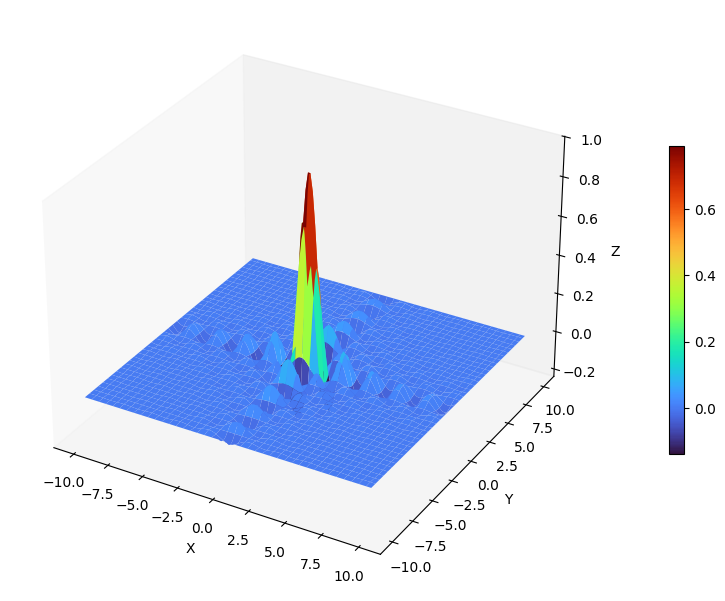

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, cmap='turbo')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.grid(False)


fig.colorbar(surf, ax=ax, pad=0.1, shrink=0.5)

plt.show()

## **Build, train, and evaluate ANFIS**

Combine the input features into a single array and split the data into training and testing subsets to evaluate model performance consistently.

In [4]:
from sklearn.model_selection import train_test_split

X = np.c_[x.ravel(), y.ravel()]
y = z.ravel()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 10080
Testing set size: 4320


This block defines and trains an Adaptive Neuro-Fuzzy Inference System (ANFIS) regression model using the ANFISRegressor class from anfis_toolbox.
The model employs 15 Gaussian membership functions (MFs) per input variable, initialized via Fuzzy C-Means (FCM) clustering to provide data-driven fuzzy partitions.
Training is performed using a hybrid learning strategy that combines Adam-based gradient descent for premise parameters (the membership function parameters) with least-squares optimization for consequent parameters.

In [10]:
from anfis_toolbox import ANFISRegressor

model = ANFISRegressor(n_mfs=15, optimizer="hybrid_adam", epochs=15, batch_size=128, learning_rate=1e-2, random_state=42, init="fcm", verbose=True)
model.fit(X_train, y_train, validation_data=(X_test, y_test))

Epoch 1 - train_loss: 0.000096 - val_loss: 0.000095
Epoch 2 - train_loss: 0.000090 - val_loss: 0.000089
Epoch 3 - train_loss: 0.000085 - val_loss: 0.000083
Epoch 4 - train_loss: 0.000080 - val_loss: 0.000078
Epoch 5 - train_loss: 0.000076 - val_loss: 0.000074
Epoch 6 - train_loss: 0.000072 - val_loss: 0.000070
Epoch 7 - train_loss: 0.000069 - val_loss: 0.000067
Epoch 8 - train_loss: 0.000066 - val_loss: 0.000064
Epoch 9 - train_loss: 0.000064 - val_loss: 0.000062
Epoch 10 - train_loss: 0.000063 - val_loss: 0.000061
Epoch 11 - train_loss: 0.000061 - val_loss: 0.000059
Epoch 12 - train_loss: 0.000061 - val_loss: 0.000059
Epoch 13 - train_loss: 0.000060 - val_loss: 0.000059
Epoch 14 - train_loss: 0.000061 - val_loss: 0.000059
Epoch 15 - train_loss: 0.000061 - val_loss: 0.000059


ANFISRegressor(n_mfs=15, mf_type='gaussian', init='fcm', overlap=0.5, margin=0.1, random_state=42, optimizer='hybrid_adam', learning_rate=0.01, epochs=15, batch_size=128)
├─ model_: TSKANFIS, n_inputs=2, n_rules=225, inputs=['x1', 'x2'], mfs_per_input=[15, 15]
├─ optimizer_: HybridAdamTrainer(learning_rate=0.01, epochs=15, verbose=True)
├─ training_history_: train=15 (last=0.0001), val=15 (last=0.0001)
├─ rules_: 225 learned
└─ feature_names_in_: x1, x2

In [11]:
results = model.evaluate(X_test, y_test)

ANFISRegressor evaluation:
  mse: 0.000059
  rmse: 0.007690
  mae: 0.003598
  median_absolute_error: 0.001513
  mean_bias_error: 0.000021
  max_error: 0.142773
  std_error: 0.007690
  explained_variance: 0.969698
  r2: 0.969698
  mape: 172.732437
  smape: 111.957422
  pearson: 0.985130


After training, the model is used to generate predictions for the entire input space. The predicted output values are reshaped to match the original grid format of the dataset, enabling a direct visual comparison with the target surface.
A 3D surface plot is then created using Matplotlib to visualize the ANFIS model’s response over the input domain.

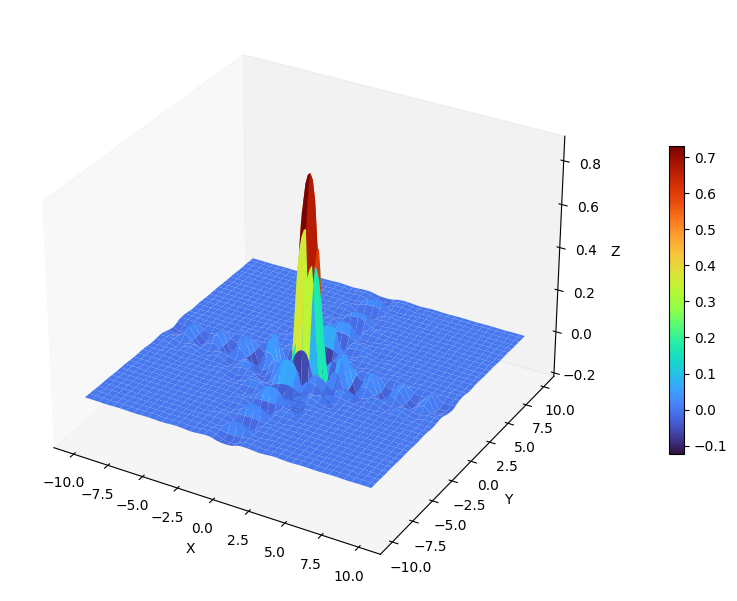

In [12]:
z_predict = model.predict(X)
z_predict = z_predict.reshape(z.shape)
x = X[:, 0].reshape(x.shape)
y = X[:, 1].reshape(x.shape)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z_predict, cmap='turbo')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Remove grid lines
ax.grid(False)

# Add a colorbar and shrink it
fig.colorbar(surf, ax=ax, pad=0.1, shrink=0.5) # Adjust shrink value as needed

plt.show()